[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/examples/ZINB_example_example.ipynb)

# Imports

In [13]:
from lightgbmlss.model import *
from lightgbmlss.distributions.ZINB import *

from sklearn.model_selection import train_test_split
import pandas as pd
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)

# Data

In [2]:
# For more information on the dataset see: https://stats.oarc.ucla.edu/stata/dae/zero-inflated-poisson-regression/
data = pd.read_stata("http://www.stata-press.com/data/r10/fish.dta")
y = data["count"].values
X = data.drop(columns="count")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In [3]:
# Specifies Zero-Inflated Negative Binomial distribution. See ?ZINB for an overview.
lgblss = LightGBMLSS(
    ZINB(stabilization="None",              # Options are "None", "MAD", "L2".
         response_fn_total_count="relu",    # Function to transform the total_count-parameter, e.g., "exp", "softplus" or "relu".
         response_fn_probs="sigmoid",       # Function to transform the probs-parameter, e.g., "sigmoid",
         loss_fn="nll"                      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
        )
)  

# Hyper-Parameter Optimization

In [4]:
# Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
    # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
        # param_name: str, Name of the parameter
        # value: int, Value of the parameter
    # Example: {"gpu_id": ["none", [0]]}

param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "min_gain_to_split":        ["float", {"low": 1e-8,   "high": 40,    "log": False}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                             )

[I 2023-06-15 15:04:22,084] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\LightGBMLSS-Dam57Fpb\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/05:00

[I 2023-06-15 15:04:25,963] Trial 0 finished with value: 73.10546734431021 and parameters: {'eta': 0.321402498698913, 'max_depth': 9, 'min_gain_to_split': 28.18053609091286, 'subsample': 0.6819725345892192, 'feature_fraction': 0.3820453961440182, 'boosting': 'gbdt'}. Best is trial 0 with value: 73.10546734431021.
[I 2023-06-15 15:04:32,260] Trial 1 finished with value: 60.37888041476175 and parameters: {'eta': 0.0447055831671884, 'max_depth': 9, 'min_gain_to_split': 7.573180441386256, 'subsample': 0.6409597630759871, 'feature_fraction': 0.25689884199533897, 'boosting': 'gbdt'}. Best is trial 1 with value: 60.37888041476175.
[I 2023-06-15 15:04:37,943] Trial 2 finished with value: 72.50112287915071 and parameters: {'eta': 1.34726908982569e-05, 'max_depth': 2, 'min_gain_to_split': 10.574946217343324, 'subsample': 0.2573628009606715, 'feature_fraction': 0.4618919521671847, 'boosting': 'gbdt'}. Best is trial 1 with value: 60.37888041476175.
[I 2023-06-15 15:04:41,928] Trial 3 finished with

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95] 

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1,0,17,9,3,0,2,6,2,0,...,2,0,21,8,0,71,4,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,44,47,3,30,15,0,0,32,7,...,13,41,109,0,30,1,379,3,8,17
3,10,10,71,0,21,19,3,34,0,179,...,28,6,184,3,1,84,258,3,7,79
4,0,0,0,2,0,0,2,1,4,2,...,1,5,0,1,4,0,8,4,1,6


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,0,14
1,0,0
2,0,117
3,0,175
4,0,7


In [9]:
pred_params.head()

,total_count,probs,gate
0,0.311453,0.909880,0.001
1,0.014769,0.600037,0.001
2,0.313132,0.987071,0.001
3,0.297513,0.991554,0.001
4,0.296796,0.827654,0.001


# SHAP Interpretability

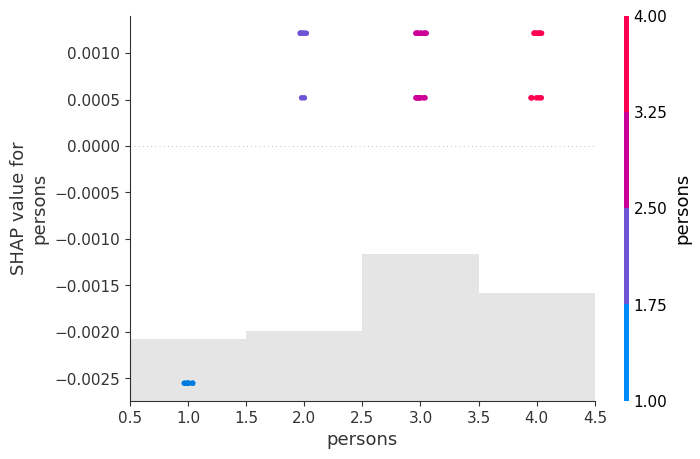

In [10]:
# Partial Dependence Plot of rate parameter
lgblss.plot(X_test,
            parameter="total_count",
            feature="persons",
            plot_type="Partial_Dependence")

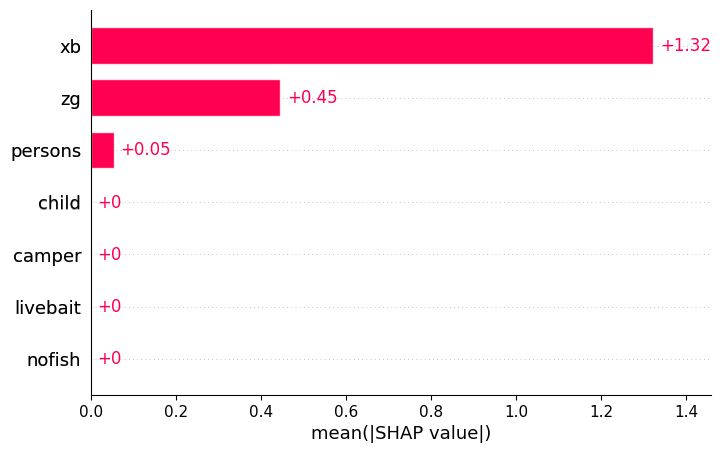

In [11]:
# Feature Importance of gate parameter
lgblss.plot(X_test,
            parameter="probs",
            plot_type="Feature_Importance")

# Density Plots of Actual and Predicted Samples

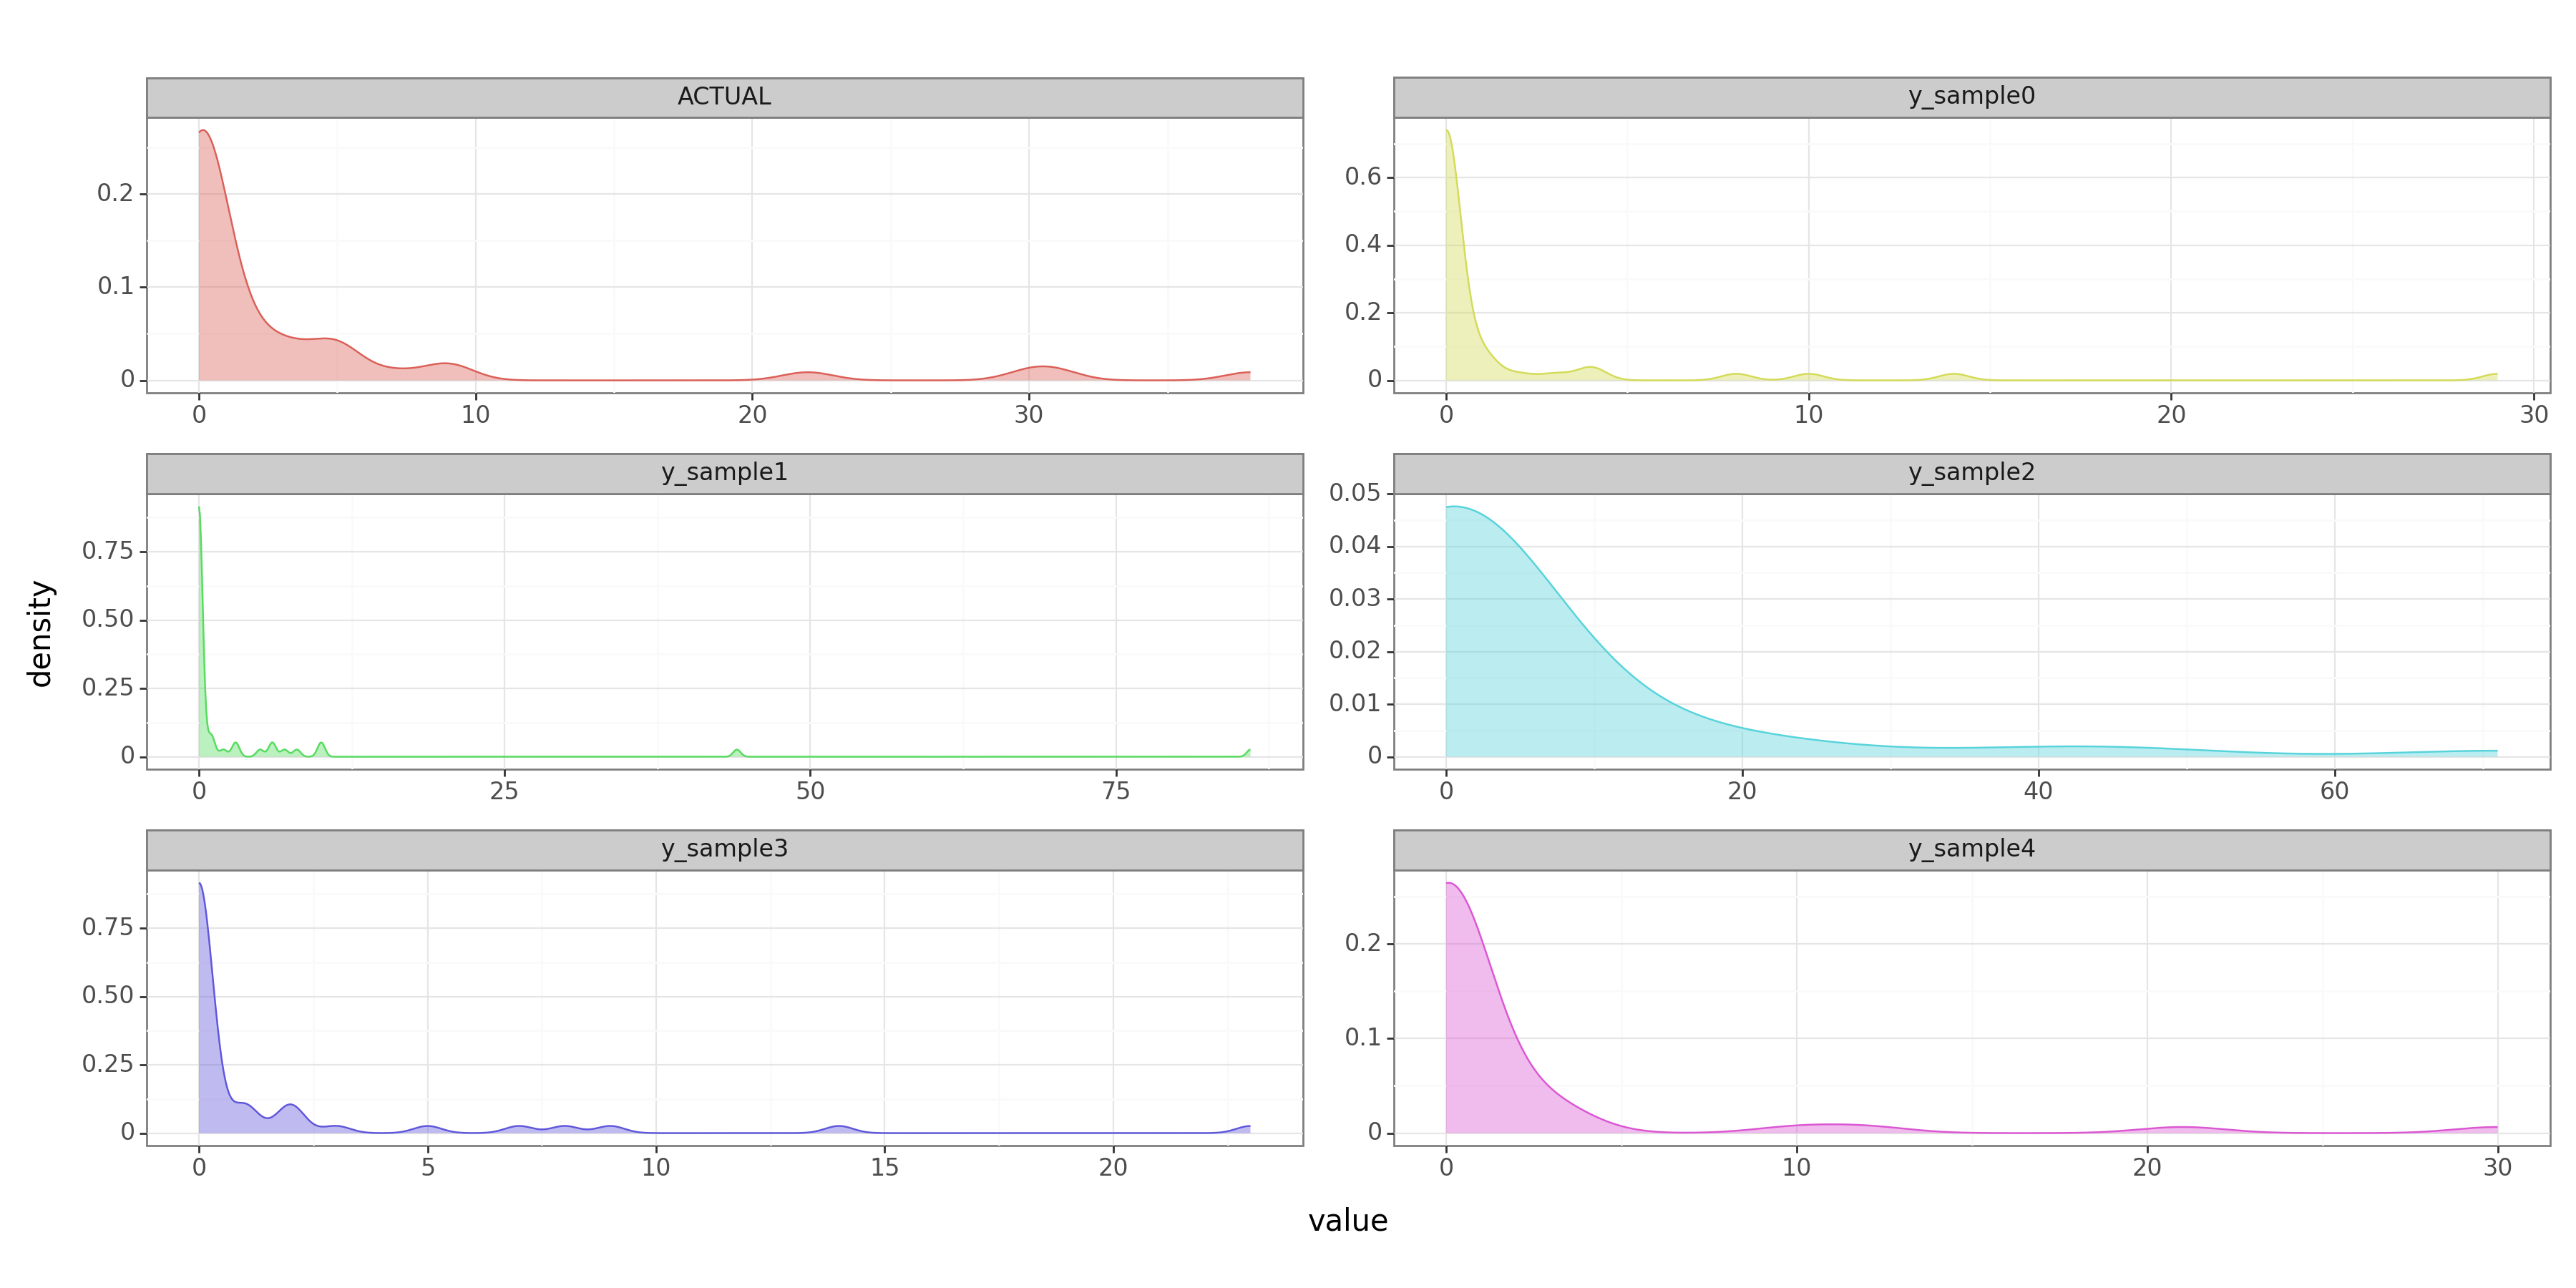

<Figure Size: (1800 x 900)>

In [14]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
              scales="free",
              ncol=2) + 
    theme_bw(base_size=15) + 
    theme(legend_position="none")
)